Optimizing hospital procedures - predicting medical costs based on patient data
===
---

In [1]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# header
%matplotlib inline
sns.set_theme()

data_path='data/'

---
# Executive summary

**Introduction / approach / limitations.**

---
# Input data and transformations

We use a dataset containing medical costs based on patient data from Kaggle ([link](https://www.kaggle.com/datasets/mirichoi0218/insurance)).

In [2]:
# load the dataset
df = pd.read_csv(data_path+"insurance.csv")

We inspect the dataset.

In [3]:
# quick view (data types / missing values / duplicates)

print(df.info())
print(df.sample(10))
print("\n")

# check for duplicates
print("Number of duplicate rows:", df.duplicated().sum())
print("\n")

# check for missing
print(df.isnull().sum())
print("\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
      age     sex     bmi  children smoker     region      charges
142    34    male  25.300         2    yes  southeast  18972.49500
930    26    male  46.530         1     no  southeast   2927.06470
879    37  female  29.500         2     no  southwest   6311.95200
997    63  female  36.850         0     no  southeast  13887.96850
143    29    male  29.735         2     no  northwest  18157.87600
1269   45    male  27.500         3     no  southwest   8615.30000
975   

---
# Exploratory data analysis

We perform exploratory data analysis to find feature candidates.

In [4]:
# candidates for features used to train the model
# ! start with all features
features_candidates = df.columns.tolist()

df = df[features_candidates]

# print(df.info())
# print("\n")

Inspect individual features and decide on relevant transformations.

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64


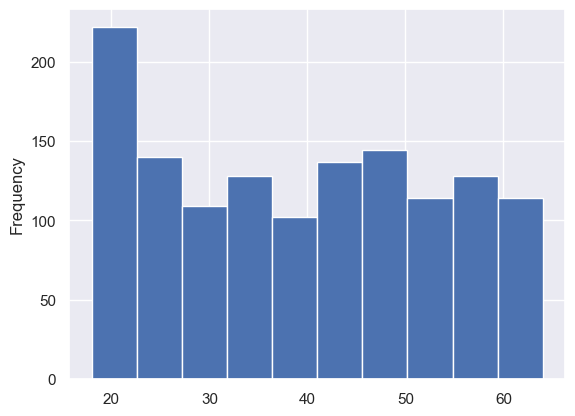

count     1338
unique       2
top       male
freq       676
Name: sex, dtype: object
sex
male      676
female    662
Name: count, dtype: int64
count    1338.000000
mean       30.663397
std         6.098187
min        15.960000
25%        26.296250
50%        30.400000
75%        34.693750
max        53.130000
Name: bmi, dtype: float64


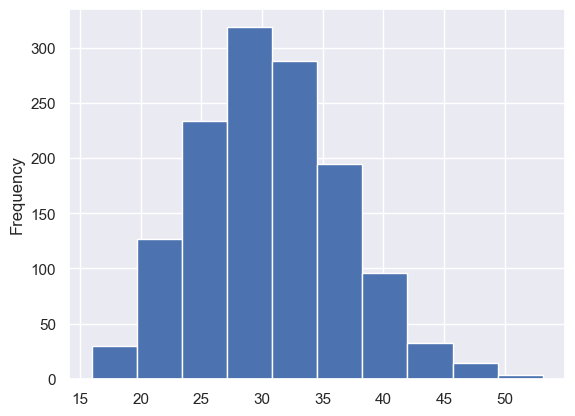

count    1338.000000
mean        1.094918
std         1.205493
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         5.000000
Name: children, dtype: float64


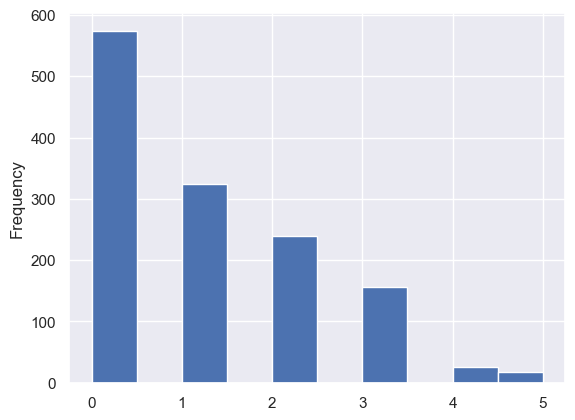

count     1338
unique       2
top         no
freq      1064
Name: smoker, dtype: object
smoker
no     1064
yes     274
Name: count, dtype: int64
count          1338
unique            4
top       southeast
freq            364
Name: region, dtype: object
region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64
count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64


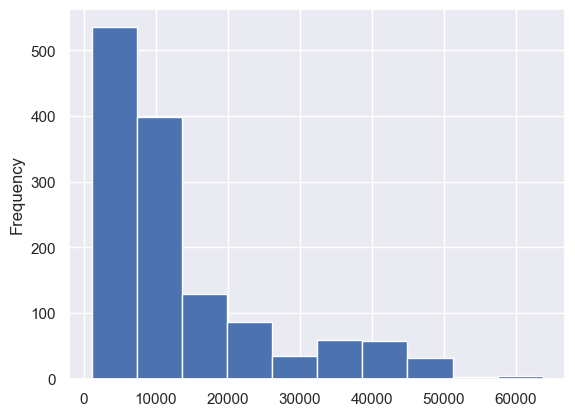

In [5]:
from pandas.api.types import is_numeric_dtype
  
# get basic characteristics
for f in features_candidates:
    print(df[f].describe())
    if is_numeric_dtype(df[f]):
        df[f].plot.hist()
        plt.show()
    else:
        print(df[f].value_counts(dropna=False))
        plt.show()

We inspect correlations between variables.

In [6]:
# check correlations
# ! numerical columns only

print(df.info())
correlations = df.select_dtypes(include=['number']).corr()
print(correlations.round(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
           age   bmi  children  charges
age       1.00  0.11      0.04     0.30
bmi       0.11  1.00      0.01     0.20
children  0.04  0.01      1.00     0.07
charges   0.30  0.20      0.07     1.00


---
# Model building

## Feature engineering

Tranform data into a format usable by the model.

In [7]:
# encode categorical data (one-hot encoding)
# ? adapt to keep flag for all regions
df = pd.get_dummies(data = df, drop_first = True) # drop_fist: encode n values using n-1 varaibles

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1338 non-null   int64  
 1   bmi               1338 non-null   float64
 2   children          1338 non-null   int64  
 3   charges           1338 non-null   float64
 4   sex_male          1338 non-null   bool   
 5   smoker_yes        1338 non-null   bool   
 6   region_northwest  1338 non-null   bool   
 7   region_southeast  1338 non-null   bool   
 8   region_southwest  1338 non-null   bool   
dtypes: bool(5), float64(2), int64(2)
memory usage: 48.5 KB
None


Make final checks and select features.

In [8]:
# check correlations between features and the target
correlations = df.corr().abs()
print(correlations["charges"].sort_values(ascending=False).round(2))
print("\n")

# select final features for model building
# ! keep all for now
features_final = df.columns.tolist()
features_final.remove("charges")

charges             1.00
smoker_yes          0.79
age                 0.30
bmi                 0.20
region_southeast    0.07
children            0.07
sex_male            0.06
region_southwest    0.04
region_northwest    0.04
Name: charges, dtype: float64




## Model training

Split the dataset.

In [9]:
# select final features
X = df[features_final]
y = df["charges"]

# split datasets into training / test sets
# ! test set - 20% of original dataset / random_state: seed that ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=268)

Build a baseline model.

In [10]:
# build the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Inspect the model coefficients.

In [11]:
# get trained parameters
coefficients_names = model.feature_names_in_
coefficients = model.coef_.round(2)
intercept = model.intercept_.round(2)

# make a df for readability
coefficients_df = pd.DataFrame({"feature": coefficients_names, "coefficient": coefficients})
# coefficients_df.loc[:, "coefficient_abs"] = coefficients_df["coefficient"].abs()

# print
print(coefficients_df.sort_values("coefficient", ascending=False))
print(f"Intercept: {intercept}")
print("\n")

            feature  coefficient
4        smoker_yes     23771.89
2          children       345.08
1               bmi       309.21
0               age       269.44
3          sex_male       -67.07
5  region_northwest      -503.99
6  region_southeast      -602.16
7  region_southwest     -1213.51
Intercept: -11432.94




## Model validation

We use error metrics and residuals analysis.

Residuals mean: -2.0739879180616306e-12




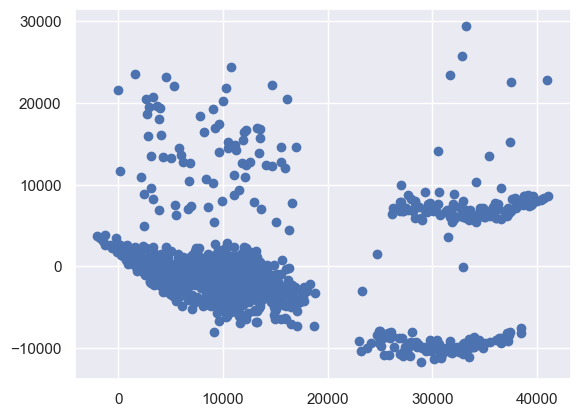

MSE: 37567944.307250604
RMSE: 6129.269475822596
R2: 0.7470936779281345




In [12]:
# validate (residuals mean / residual plot / MSE / coefficient of determination)
predictions = model.predict(X_train)

# check residuals
residuals = y_train - predictions

residual_mean = residuals.mean()
print(f"Residuals mean: {residual_mean}")
print("\n")

plt.scatter(predictions, residuals)
plt.show()

# compute metrics
metrics_mse = mean_squared_error(y_train, predictions)
metrics_rmse = mean_squared_error(y_train, predictions, squared=False) # make it same dimension as the outcome
metrics_r2 = r2_score(y_train, predictions)

# print metrics
print(f"MSE: {metrics_mse}")
print(f"RMSE: {metrics_rmse}")
print(f"R2: {metrics_r2}")
print("\n")

The model performs well, we use it on the test data.

In [13]:
# use on test data
# ? compute metrics / show results / interpret / compare to training data
# y_pred_test = model.predict(X_test)

---
# Findings

Interpret the model / results.

Determine best predictors.

---
# Conclusions